In [1]:
import _init_paths

import cv2
import torch
import numpy as np
import os

import pandas as pd
from detectors.detector_factory import detector_factory
from datasets.dataset_factory import get_dataset
from models.decode import ddd_decode
from utils.debugger import Debugger
from opts import opts

from matplotlib import pyplot as plt

In [2]:
from utils.image import transform_preds
# from utils.post_process import ddd_post_process,ddd_post_process_2d,get_alpha,get_alpha_ori

In [3]:
MODEL_PATH = '../models/20221128_initial.pth'
TASK = 'ddd'
DATASET = 'kitti'
IMG_PATH = '../data/kitti/images/trainval/000079.jpg'

In [4]:
Dataset = get_dataset(DATASET, TASK)

# config init
opt = opts().init('{} --load_model {}'.format(TASK, MODEL_PATH).split(' '))
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)

detector = detector_factory[opt.task](opt)
debugger = Debugger(dataset=detector.opt.dataset, ipynb=(detector.opt.debug==3),
                        theme=detector.opt.debugger_theme)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /home/alfin/Documents/deep_learning/production/CenterNet_fish/src/lib/../../exp/ddd/default
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
Creating model...
loaded ../models/20221128_initial.pth, epoch 70


In [5]:
img_ori = cv2.imread(IMG_PATH)

img = img_ori.copy()

img_input, meta = detector.pre_process(img, detector.scales)
img_input = img_input.to(detector.opt.device)

In [6]:
# Manual

In [7]:
torch.no_grad()
torch.cuda.synchronize()

In [8]:
output = detector.model(img_input)[-1]

In [9]:
output['hm'] = output['hm'].sigmoid_()
output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
wh = output['wh'] if detector.opt.reg_bbox else None
reg = output['reg'] if detector.opt.reg_offset else None
torch.cuda.synchronize()

output.keys()

dict_keys(['hm', 'dep', 'rot', 'dim', 'wh', 'reg'])

In [11]:
for key in output.keys():
    print(key,output[key].shape)
    
# 96 = 384/4

hm torch.Size([1, 3, 96, 320])
dep torch.Size([1, 1, 96, 320])
rot torch.Size([1, 8, 96, 320])
dim torch.Size([1, 3, 96, 320])
wh torch.Size([1, 2, 96, 320])
reg torch.Size([1, 2, 96, 320])


In [12]:
# [xs, ys, scores, rot, depth, dim, wh, clses], dim=2)
# 0 xs
# 1 ys
# 2 scores
# 3-10 rot
# 11 depth
# 12-14 dim
# 15 w
# 16 h
# 17 class

# [xs, ys, scores, rot, depth, dim, wh, clses], dim=2)
# 0 xs
# 1 ys
# 2 scores
# 3-34 rot
# 35 depth
# 36-38 dim
# 39 w
# 40 h
# 41 class


dets = ddd_decode(output['hm'], output['rot'], output['dep'],
                          output['dim'], wh=wh, reg=reg, K=detector.opt.K)
dets = dets.detach().cpu().numpy()
dets.shape

(1, 100, 18)

In [13]:
# 2D Detection
# 0 xs
  # 1 ys
  # 2 scores
  # 3-18 rot
  # 19 depth
  # 20-22 dim
  # 23 w
  # 24 h
  # 25 class

In [14]:
# 0 xs
# 1 ys
# 2 scores
# 3-10 rot
# 11 depth
# 12-14 dim
# 15 w
# 16 h
# 17 class

In [16]:
down_ratio = debugger.down_ratio

for det in dets[0]:
    scores = det[2]
    class_name = int(det[-1])
    
    cx = int(det[0] * down_ratio)
    cy = int(det[1] * down_ratio)
    
    w = det[15] * down_ratio
    h = det[16] * down_ratio
    
    xmin = int(cx - w/2)
    ymin = int(cy - h/2)
    xmax = int(cx + w/2)
    ymax = int(cy + h/2)
    
    dim = list(det[12:15])
    
    depth = det[11]
    
    rot = det[3:11].reshape((1,8))
    if scores > 0.3:
#         merged = list()
#         merged += [xmin,ymin,xmax,ymax]
#         merged += (dim)
#         merged.append(depth)
#         merged.append(list(get_alpha(rot))[0])
#         merged.append(list(get_alpha(rot,is_alphay=True))[0])
#         merged.append(get_alpha(rot,is_alphay=True))
#         print(xmin,ymin,xmax,ymax)
#         print(depth)
#         print(get_alpha(rot))
#         print(get_alpha(rot,is_alphay=True))
#         print(merged)
#         print('')
        print(xmin,ymin,xmax,ymax)
        img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax), (255,0,0), 2)
        img = cv2.circle(img, (cx,cy), radius=3, color=(0, 0, 255), thickness=-1)

472 5 577 164
253 83 398 256
330 159 455 236


In [17]:
np.degrees(6.078107018266813) - np.degrees(4.171337)

109.24987454877126

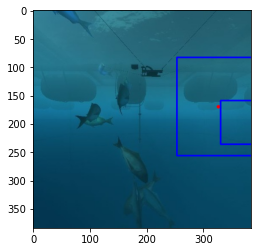

In [18]:
plt.imshow(img[...,::-1])
plt.show()

In [20]:
# 3D Detection

In [21]:
idx = np.arange(100) * (np.arange(100) > 50)
aa = np.arange(100) 
bb = np.arange(100)*2
bb

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198])

In [22]:
aa*idx + bb*(1-idx)

array([    0,     2,     4,     6,     8,    10,    12,    14,    16,
          18,    20,    22,    24,    26,    28,    30,    32,    34,
          36,    38,    40,    42,    44,    46,    48,    50,    52,
          54,    56,    58,    60,    62,    64,    66,    68,    70,
          72,    74,    76,    78,    80,    82,    84,    86,    88,
          90,    92,    94,    96,    98,   100, -2499, -2600, -2703,
       -2808, -2915, -3024, -3135, -3248, -3363, -3480, -3599, -3720,
       -3843, -3968, -4095, -4224, -4355, -4488, -4623, -4760, -4899,
       -5040, -5183, -5328, -5475, -5624, -5775, -5928, -6083, -6240,
       -6399, -6560, -6723, -6888, -7055, -7224, -7395, -7568, -7743,
       -7920, -8099, -8280, -8463, -8648, -8835, -9024, -9215, -9408,
       -9603])

In [24]:
img_dirs = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/frames/'

imgs = os.listdir(img_dirs)[:300]

for img_path in imgs:
    img_ori = cv2.imread(os.path.join(img_dirs,img_path))

    img = img_ori.copy()

    img_input, meta = detector.pre_process(img, detector.scales)
    img_input = img_input.to(detector.opt.device)

    torch.no_grad()
    torch.cuda.synchronize()

    output = detector.model(img_input)[-1]

    output['hm'] = output['hm'].sigmoid_()
    output['dep'] = 1. / (output['dep'].sigmoid() + 1e-6) - 1.
    wh = output['wh'] if detector.opt.reg_bbox else None
    reg = output['reg'] if detector.opt.reg_offset else None
    torch.cuda.synchronize()

    output.keys()

    dets = ddd_decode(output['hm'], output['rot'], output['dep'],
                              output['dim'], wh=wh, reg=reg, K=detector.opt.K)
    dets = dets.detach().cpu().numpy()

    down_ratio = debugger.down_ratio
    
    out = list()
    
    for det in dets[0]:
        scores = det[2]
        class_name = int(det[-1])

        cx = int(det[0] * down_ratio)
        cy = int(det[1] * down_ratio)

        w = det[23] * down_ratio
        h = det[24] * down_ratio

        xmin = int(cx - w/2)
        ymin = int(cy - h/2)
        xmax = int(cx + w/2)
        ymax = int(cy + h/2)

        dim = list(det[20:23])

        depth = det[19]

        rot = det[3:19].reshape((1,16))
        if scores > 0.2:
            merged = list()
            merged += [xmin,ymin,xmax,ymax]
            merged += (dim)
            merged.append(depth)
            merged.append(list(get_alpha(rot))[0])
            merged.append(list(get_alpha(rot,is_alphay=True))[0])
            out.append(merged)
        
    df = pd.DataFrame(out,columns=['xmin','ymin','xmax','ymax','h','w','l','z','alphay','alphax'])
    print(df)
    df.to_csv(os.path.join(img_dirs,'..','label_inference',os.path.splitext(os.path.basename(img_path))[0]+'.txt'),header=False,sep=' ',index=False)
        

384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax        h         w        l         z    alphay  \
0    53    32    94    89  0.33296  0.651188  0.22969  1.280955  5.922736   

     alphax  
0  2.365304  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xma

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   161    -5   250    23  0.353058  0.641126  0.310466  1.245663  6.072239   
1   204    -5   271    17  0.380112  0.667399  0.233333  1.571525  6.150950   
2    60   340    93   373  0.310988  0.554646  0.215781  1.846267  5.703817   
3    41   242    90   327  0.298928  0.593157  0.200646  0.890154  4.865228   

     alphax  
0  1.392744  
1  2.680062  
2  3.557500  
3  1.228662  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h        w         l         z    

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0     0    -6    17    32  0.282339  0.503511  0.227838  1.390065  0.212348   
1   186    13   233    62  0.338142  0.580280  0.235001  1.124147  6.235789   

     alphax  
0  3.312211  
1  3.102879  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   193    88   272   137  0.353991  0.691127  0.219513  1.432528  5.340167   
1    26   278   103   347  0.319777  0.731659  0.286902  1.252173  4.661318   
2   333     0   3

384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   181    89   270   136  0.372570  0.643272  0.255072  1.435804  5.317471   
1    41   279   104   338  0.311410  0.644602  0.197625  1.443048  4.920072   
2    17   127    54   170  0.301515  0.537252  0.270387  1.334297  5.354195   
3   100    95   141   124  0.358391  0.580328  0.242934  1.564902  5.552471   
4   339     0   356    44  0.250633  0.538326  0.193513  1.270556  6.010575   

     alphax  
0  0.902007  
1  1.679782  
2  4.279263  
3  5.893787  
4  1.705120  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax        h         w         l        z   alphay  \
0    28   258    95   351  0.27087  0.567345  0.194999  0.71576  5.39367   

     alphax  
0  1.083279  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax   

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h        w         l         z    alphay  \
0    17   337    50   384  0.339839  0.50074  0.173436  1.276813  5.404929   

    alphax  
0  3.25715  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   -13    -8    33    28  0.388205  0.629461  0.313351  1.409375  0.099847   
1    41   247    98   330  0.312110  0.588061  0.232849  0.850356  5.131765   
2    44    -5   103    17  0.343249  0.603246  0.210788  1.581174  6.138223   

     alphax  
0  1.753252  
1  0.3

   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    35   248    96   321  0.319008  0.606739  0.252332  1.084741  5.108408   
1    -3    -5    31    31  0.276197  0.552807  0.238649  1.241028  0.023733   

     alphax  
0  1.234915  
1  2.383239  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   210    77   263   134  0.284305  0.606127  0.204684  1.400694  5.566178   
1    36   281    93   354  0.324434  0.611644  0.190905  1.005798  5.029945   

     alphax  
0  0.438891  
1  2.404325  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    48   258   105   327  0.289941  0.510637  0.204106  1.019644  5.328814   

     alphax  
0  2.112638  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Column

384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    26    20    89    87  0.350703  0.661725  0.238275  1.032451  6.019070   
1    13   257    84   352  0.322293  0.572393  0.240948  0.648510  5.257930   
2     0     1    52    42  0.332817  0.647713  0.263400  1.151127  0.317163   

     alphax  
0  2.640823  
1  1.034534  
2  1.913360  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   217    -8   282    20  0.337400  0.681674  0.207637  1.424308  6.18173

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   101    12   142    47  0.301046  0.612399  0.247777  1.397323  0.156371   
1    18   223    95   322  0.315076  0.524065  0.198853  0.761992  5.530609   
2    -4    -7    16    51  0.322380  0.516907  0.175892  1.148111  6.277012   

     alphax  
0  2.282834  
1  1.713039  
2  1.935062  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    17    29    58   134  0.368853  0.652341  0.254353  1.001642  0.380131   
1  

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0   107    40   126    81  0.305240  0.588730  0.201101  1.779083  5.741874   
1     8   106    35   151  0.390350  0.571186  0.233610  1.130691  5.944674   
2    -5   -11    25    37  0.327004  0.516114  0.215204  1.155196  0.294998   

     alphax  
0  3.967425  
1  0.501287  
2  2.618100  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torc

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    82    21   127    60  0.254569  0.617561  0.244172  1.222039  5.923188   

     alphax  
0  2.202906  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  y

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    57    23   106    84  0.315737  0.673337  0.260982  1.397015  5.599853   
1    21   298    70   351  0.302214  0.564108  0.172940  1.541129  5.432514   
2   -11    -8    31    34  0.334726  0.560139  0.309464  1.261537  0.320904   
3   203    39   238   114  0.316778  0.616598  0.179269  1.081234  5.801192   
4    27   256    72   337  0.358456  0.630364  0.230171  0.828053  5.267286   

     alphax  
0  2.482897  
1  3.202896  
2  0.904449  
3  2.952070  
4  2.036961  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, h, w, l, z, alphay, alphax]
Index: []
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    75    -9   150    75  0.319382  0.593835  0.208781  0.850539  5.561299   
1   210     2   263    55  0.245996  0.525561  0.211393  0.936651  0.314238   
2    25   260    90   357  0.335963  0.638055  0.236586  0.668645  5.315763   

     alphax  
0  1.553820  
1  1.248358  
2  0.385702  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torc

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    80     1   131    80  0.303120  0.601869  0.200568  0.964533  5.543928   
1   214    -3   277    45  0.263977  0.521525  0.254896  0.786950  5.864930   
2    16   118    43   155  0.349123  0.543923  0.211397  1.245693  5.800058   
3    26   247   105   354  0.339579  0.610220  0.176334  0.871052  5.103601   
4   205    39   228    90  0.307880  0.503666  0.154398  1.330920  5.700345   

     alphax  
0  2.183812  
1  2.109025  
2  2.770387  
3  1.359143  
4  2.971682  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses

xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    -5    -7    17    51  0.350023  0.571843  0.232413  1.248189  6.191457   
1    20   333    53   380  0.306450  0.574607  0.109786  1.396106  5.647215   

     alphax  
0  1.160883  
1  2.826438  
384 384
xs torch.Size([1, 100, 1]) ys torch.Size([1, 100, 1])
scores torch.Size([1, 100, 1])
rot torch.Size([1, 100, 16])
depth torch.Size([1, 100, 1])
dim torch.Size([1, 100, 3])
wh torch.Size([1, 100, 2])
clses torch.Size([1, 100, 1])
   xmin  ymin  xmax  ymax         h         w         l         z    alphay  \
0    17     7    80    68  0.376989  0.736200  0.213737  1.329340  6.229578   
1   -17    -5    37    25  0.396990  0.592015  0.293413  1.228225  0.163457   
2   -13   -12    